In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import time
from functools import partial

import jax
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from ising_mcmc.cpu.fm import sweeps as sweeps_cpu
from ising_mcmc.cuda.fm import sweeps as sweeps_cuda
from ising_mcmc.jax.fm import sweeps as sweeps_jax
from ising_mcmc.pallas.fm import sweeps as sweeps_pallas

In [3]:
rng = np.random.default_rng(0)

In [4]:
l = 512

In [5]:
tc = 2.269
temps = tc * np.array([0.9, 1.0, 1.1])
nt = len(temps)

In [6]:
spin = 2 * rng.binomial(1, 0.5, size=(nt, l, l)) - 1
hext = np.zeros((nt, l, l), dtype=np.float32)

In [7]:
spin.shape

(3, 512, 512)

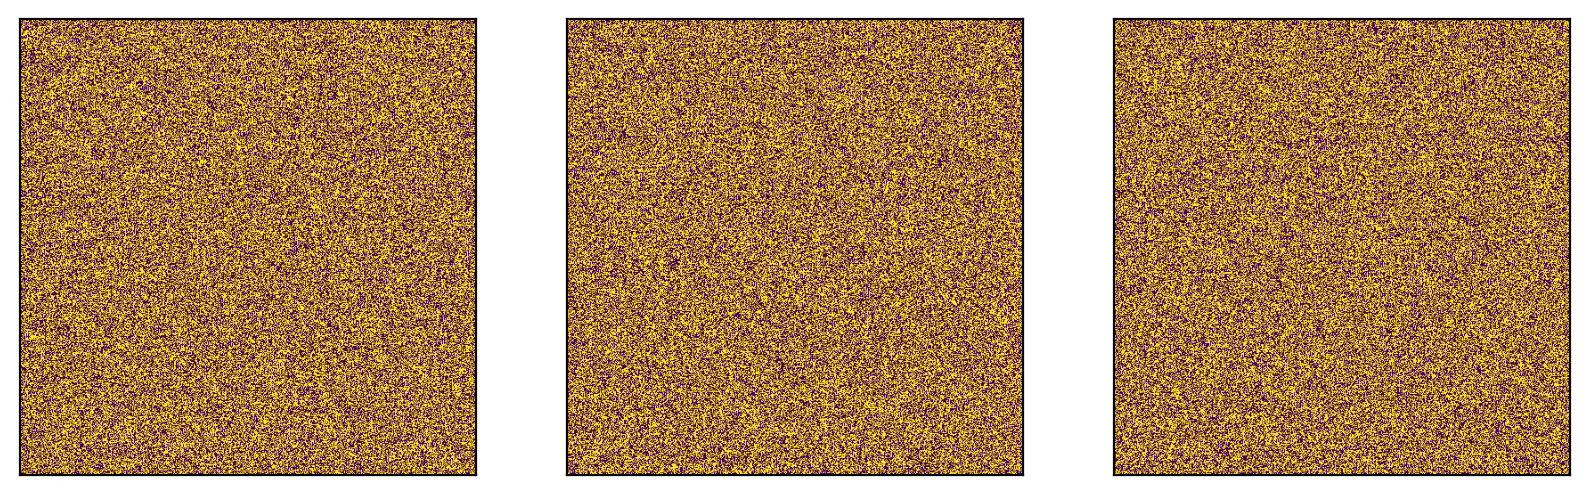

In [8]:
_, axs = plt.subplots(1, 3, figsize=(10, 3))
for s_t, ax in zip(spin, axs):
    ax.imshow(s_t)
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
n_sweeps = 1_000

In [10]:
%%time
spin_, accept_rate, m2avg, m4avg = sweeps_cpu(spin, hext, temps, n_sweeps, 0)

CPU times: user 6.59 s, sys: 5.6 ms, total: 6.6 s
Wall time: 6.61 s


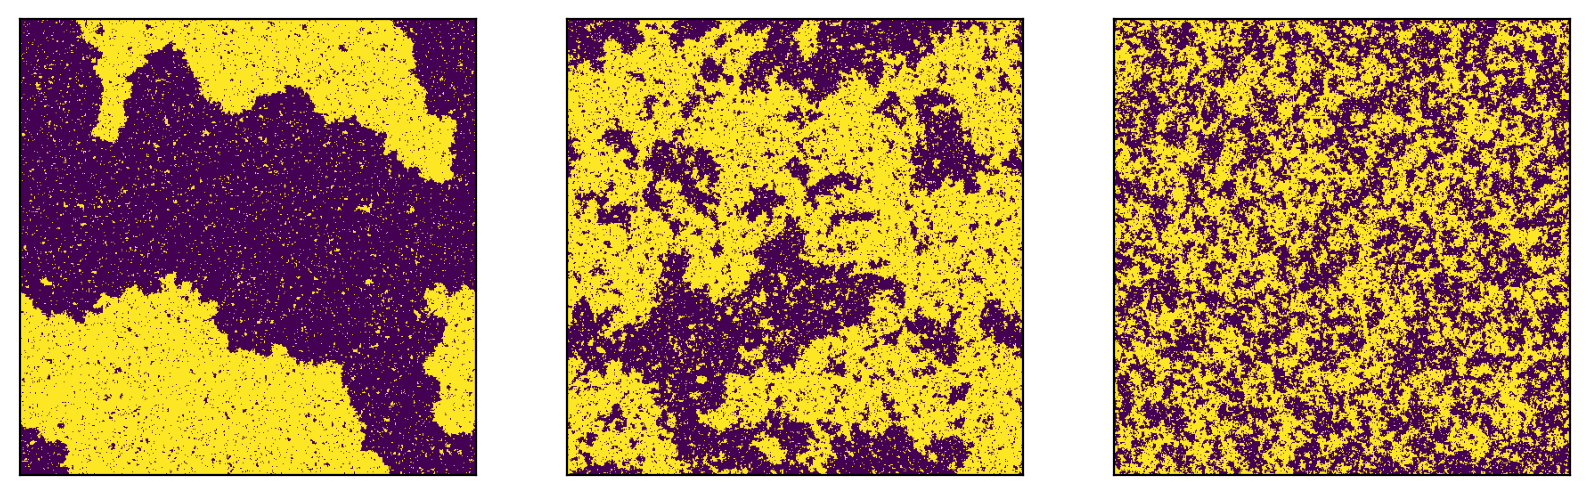

In [11]:
_, axs = plt.subplots(1, 3, figsize=(10, 3))
for s_t, ax in zip(spin_, axs):
    ax.imshow(s_t)
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
%%timeit
spin_, accept_rate, m2avg, m4avg = sweeps_cuda(spin, hext, temps, 1_000, 0)

77.5 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


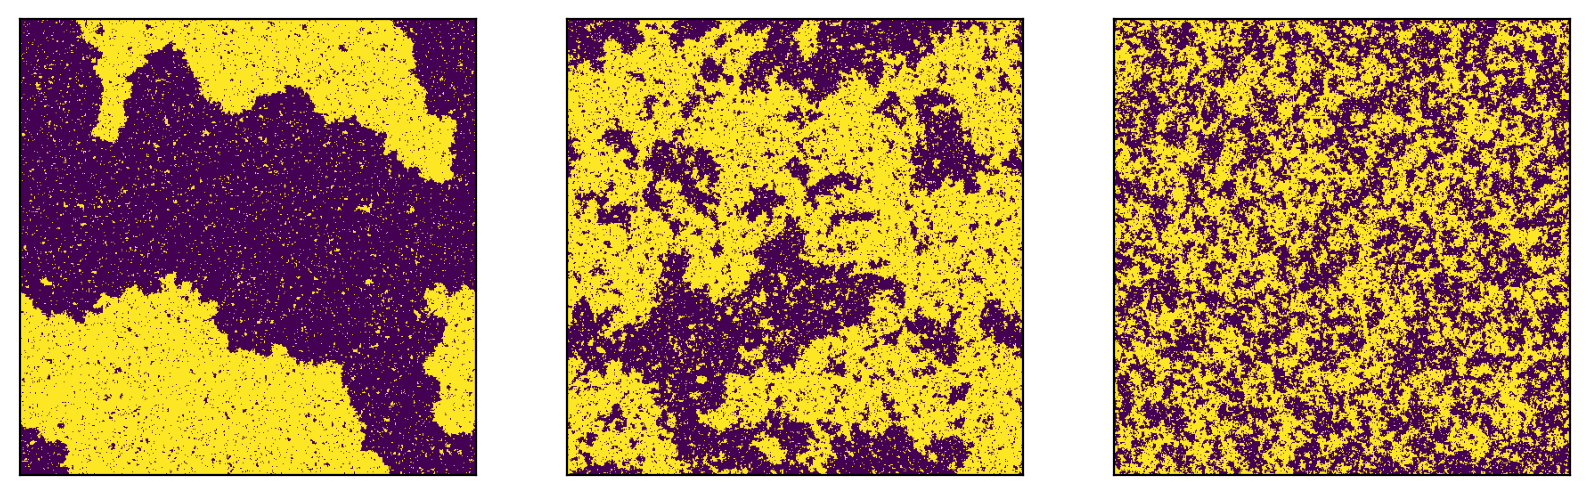

In [13]:
_, axs = plt.subplots(1, 3, figsize=(10, 3))
for s_t, ax in zip(spin_, axs):
    ax.imshow(s_t)
    ax.set_xticks([])
    ax.set_yticks([])

In [14]:
%%timeit
keys = jax.random.split(jax.random.key(1), (len(temps), n_sweeps))
sweeps_jax_batched = jax.vmap(sweeps_jax)
spin_, accept_rate, m2avg, m4avg = jax.block_until_ready(
    sweeps_jax_batched(keys, spin, hext, temps)
)

42.4 ms ± 756 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


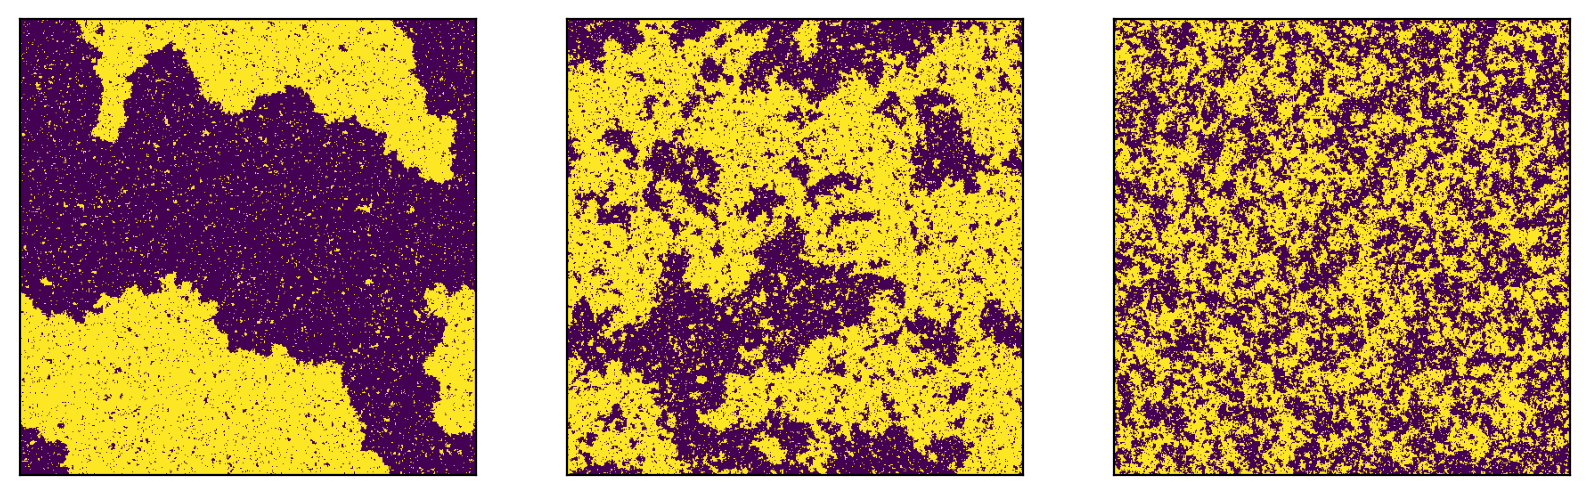

In [15]:
_, axs = plt.subplots(1, 3, figsize=(10, 3))
for s_t, ax in zip(spin_, axs):
    ax.imshow(s_t)
    ax.set_xticks([])
    ax.set_yticks([])

In [16]:
%%timeit
keys = jax.random.split(jax.random.key(1), (len(temps), n_sweeps))
sweeps_pallas_batched = jax.vmap(partial(sweeps_pallas, tile_size=16))
spin_, accept_rate, m2avg, m4avg = jax.block_until_ready(
    sweeps_pallas_batched(keys, spin, hext, temps)
)

288 ms ± 3.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


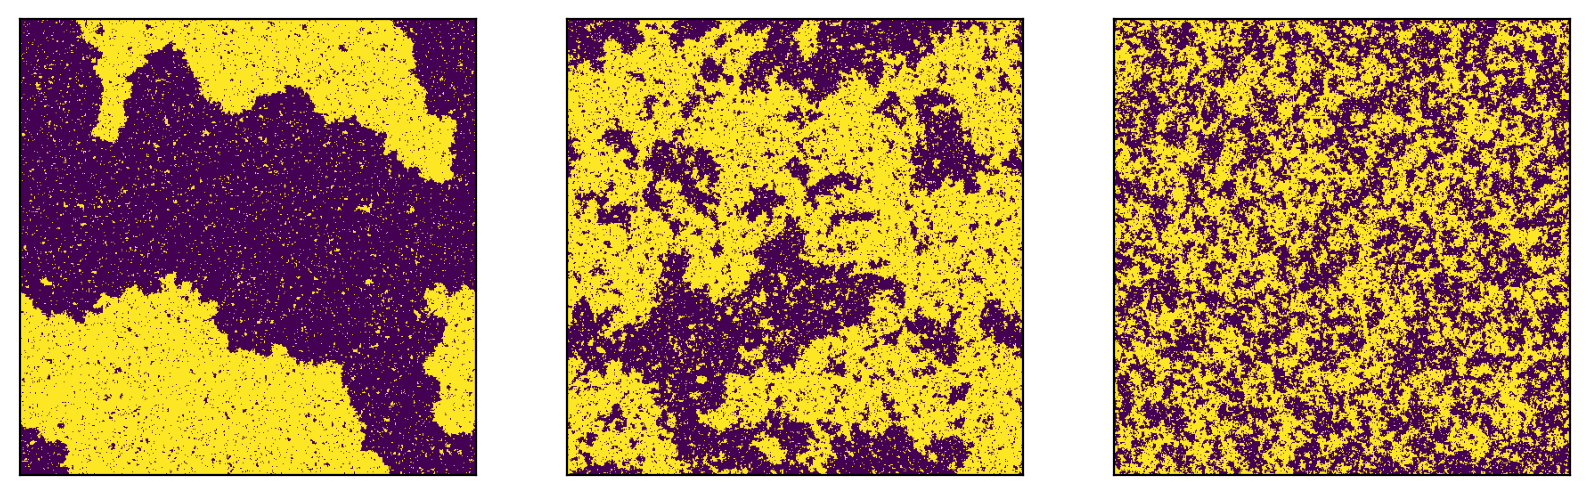

In [17]:
_, axs = plt.subplots(1, 3, figsize=(10, 3))
for s_t, ax in zip(spin_, axs):
    ax.imshow(s_t)
    ax.set_xticks([])
    ax.set_yticks([])

In [18]:
key = jax.random.key(1)
n_trials = 10


def time_sweeps_pallas_batched(key, tile_size: int, n_iters: int, n_warmup: int = 3):
    sweeps_pallas_batched = jax.vmap(partial(sweeps_pallas, tile_size=tile_size))

    def run(key):
        return sweeps_pallas_batched(key, spin, hext, temps)

    key, subkey = jax.random.split(key)
    keys_by_temp_by_iter = jax.random.split(subkey, (n_warmup, len(temps), n_sweeps))

    for keys_by_temp in keys_by_temp_by_iter:
        _ = jax.block_until_ready(run(keys_by_temp))

    keys_by_temp_by_iter = jax.random.split(key, (n_iters, len(temps), n_sweeps))

    t0 = time.perf_counter()
    for keys in keys_by_temp_by_iter:
        _ = jax.block_until_ready(run(keys))
    t1 = time.perf_counter()

    dt = t1 - t0

    return dt / n_iters


results = [
    {tile_size: time_sweeps_pallas_batched(key, tile_size, 10, 3)}
    for tile_size in tqdm([1, 2, 4, 8, 16, 32, 64])
]

  0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
results

[{1: 2.043109969096258},
 {2: 0.7354991726984735},
 {4: 0.38021539979963564},
 {8: 0.29006163330050183},
 {16: 0.27861092319944875},
 {32: 0.3145037924987264},
 {64: 0.4249342177005019}]